In [3]:
!pip install scikit-learn seaborn matplotlib pandas numpy scikit-image pillow

In [2]:
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from skimage.feature import match_descriptors, plot_matches, SIFT
from skimage.transform import resize
from skimage import color, io
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from scipy.fftpack import rfft, irfft
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import pandas as pd
import pickle
import os

In [22]:
#source: https://towardsdatascience.com/image-processing-with-python-application-of-fourier-transformation-5a8584dc175b
def fourier_transform(image):
    image = np.array(image)
    fourier_image = np.fft.fftshift(np.fft.fft2(image))
    return fourier_image

def filter_fourier_image(fourier_image, low_cutoff, high_cutoff):  
    # Create a mask for the desired frequency range
    rows, cols = fourier_image.shape
    crow, ccol = rows//2, cols//2
    
    # Create a grid of distances from the center
    x = np.arange(rows).reshape((rows, 1))  # column vector
    y = np.arange(cols).reshape((1, cols))  # row vector
    distances = np.sqrt((x - crow) ** 2 + (y - ccol) ** 2)

    # Create a bandpass filter mask
    mask = (distances > low_cutoff) & (distances < high_cutoff)
    filtered_image = fourier_image * mask

    return filtered_image

def inverse_fourier_transform(f_transform ):
    image = abs(np.fft.ifft2(f_transform))
    return image

# source: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html https://kushalvyas.github.io/BOV.html
def sift_features(images):
    descriptor_extractor = SIFT()
    sift_features = []

    for i, img in enumerate(images):
        print(f'{i} of {len(images)}')
        descriptor_extractor.detect_and_extract(img)
        descriptors = descriptor_extractor.descriptors
        if descriptors is not None:
            sift_features.append(descriptors)
            
    return sift_features


def bag_of_visual_words(sift_features, K = 100):    
    # Concatenate all descriptors into a single array
    all_descriptors = np.vstack(sift_features)
    
    # set number of visual words 
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(all_descriptors)

    # Get the visual words (cluster centers)
    visual_words = kmeans.cluster_centers_
 
    histograms = []
    for i, descriptors in enumerate(sift_features):
        # Predict which visual word each descriptor belongs to
        if descriptors.size != 0:
            visual_word_indices = kmeans.predict(descriptors)
            histogram, _ = np.histogram(visual_word_indices, bins=np.arange(K + 1))
            histograms.append(histogram)
        else:
            # Append a histogram of zeros if no descriptors found
            histograms.append(np.zeros(K))

    # Create Bag-of-Visual-Words histograms
    return np.array(histograms)


def plot_ROC(y_test, y_scores):
    n_classes = len(set(labels))
    # Calculate ROC and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting ROC Curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.show()

    # Print AUC values for each class
    for i in range(n_classes):
        print(f'AUC for class {i}: {roc_auc[i]:.2f}')



# Big Cats

In [4]:
# path to data directory
base_dir = 'Data-PR-As2/BigCats'
image_data = []
labels = []

max_height = 0
max_width = 0

# Loop over each folder in the directory
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            # Load the image
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)

            # Get the image size
            width, height = np.array(img).shape[:2]
            max_width = max(max_width, width)
            max_height = max(max_height, height)
            
            # Append the image array and the label (category/folder name)
            image_data.append(img)
            labels.append(category)

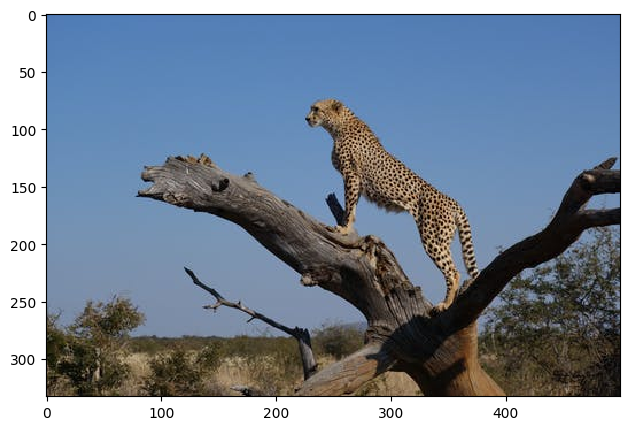

In [5]:
io.imshow(np.array(image_data[0]))

In [6]:
target_size = (max_width, max_height)
resized_images = [img.resize(target_size, Image.Resampling.LANCZOS) for img in image_data]

In [16]:
# Convert the data to numpy arrays
X = np.array(resized_images)
y = np.array(labels)

# Encode labels into numeric format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_bin = label_binarize(y_encoded, classes=np.arange(len(set(labels))))

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

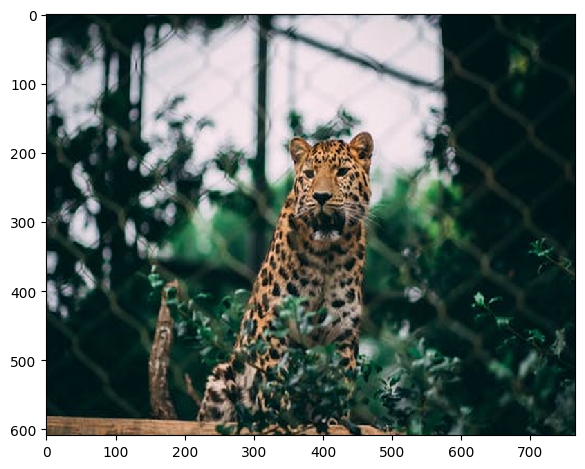

In [9]:
io.imshow(np.array(X_train[0]))

## Feature selection & dimensionality reduction

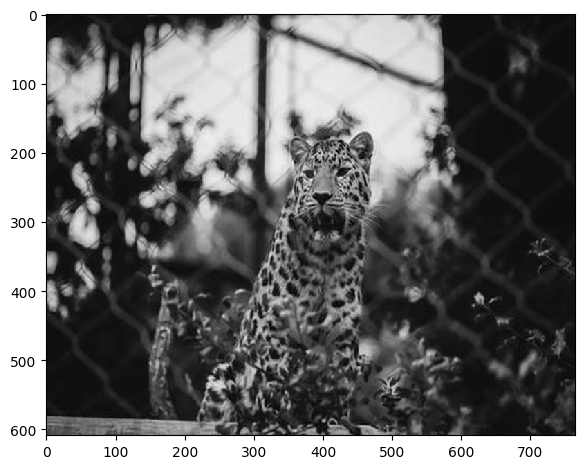

In [10]:
# Convert to grayscale
X_train_gs = [color.rgb2gray(img) for img in X_train]
X_test_gs = [color.rgb2gray(img) for img in X_test]
io.imshow(np.array(X_train_gs[0]))

### Fourier transform

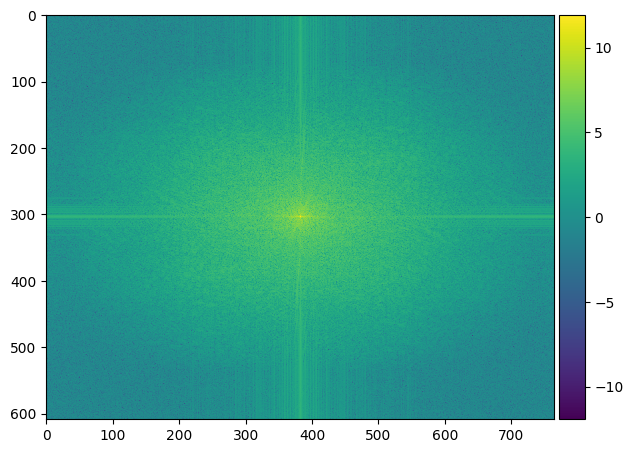

In [12]:
fft_images_train = [fourier_transform(img) for img in X_train_gs]
fft_images_test = [fourier_transform(img) for img in X_test_gs]
io.imshow(np.log(abs(fft_images_train[0])), cmap='viridis');

/home/madojo/AI/PR/assignment2/env/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


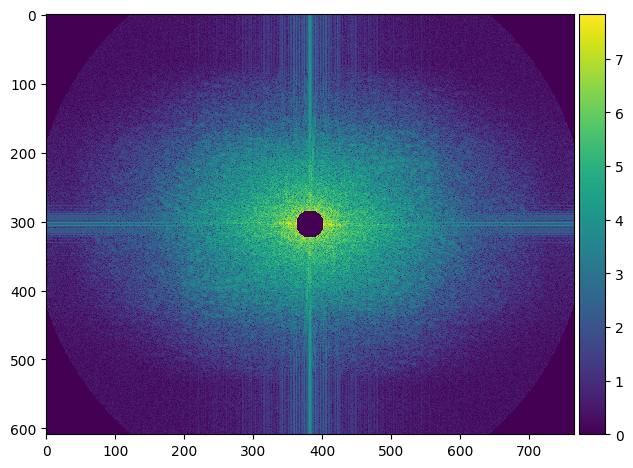

In [13]:
low_cutoff = 20
high_cutoff = 400
filtered_ftt_images_train = [filter_fourier_image(img, low_cutoff, high_cutoff) for img in fft_images_train]
filtered_ftt_images_test = [filter_fourier_image(img, low_cutoff, high_cutoff) for img in fft_images_test]
io.imshow(np.log(1+abs(filtered_ftt_images_train[0])), cmap='viridis');

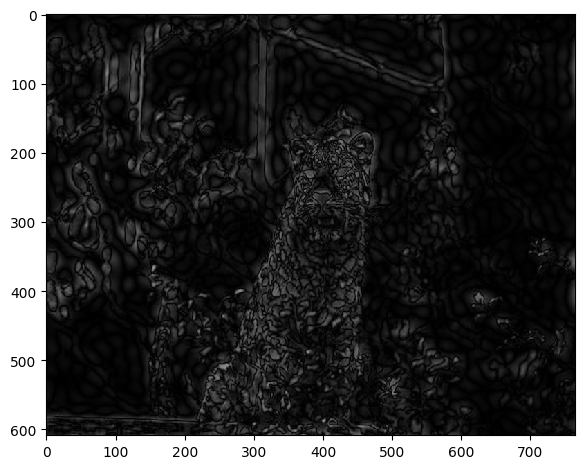

In [14]:
ifft_images_train = [inverse_fourier_transform(f) for f in filtered_ftt_images_train]
ifft_images_test = [inverse_fourier_transform(f) for f in filtered_ftt_images_test]
io.imshow(abs(ifft_images_train[0]), cmap='gray')

### SIFT (with bag-of-visual-words)

In [12]:
sift_features_train = sift_features(X_train_gs)
sift_features_test = sift_features(X_test_gs)

with open('sift_train.pkl', 'wb') as file:
    pickle.dump(sift_features_train, file)

with open('sift_test.pkl', 'wb') as file:
    pickle.dump(sift_features_test, file)

0 of 136
1 of 136
2 of 136


KeyboardInterrupt: 

In [47]:
image_histograms_train = bag_of_visual_words(sift_features_train, 100)
image_histograms_test = bag_of_visual_words(sift_features_test, 100)

## Classification

### Original data

#### Logistic Regression     

In [29]:
lm = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=200)
lm.fit([x.flatten() for x in X_train], y_train)

# Make predictions
y_pred = lm.predict([x.flatten() for x in X_test])
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

/home/madojo/AI/PR/assignment2/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=200, multi_class='ovr')

#### Naive Bayes

In [36]:
gnb = GaussianNB()
gnb.fit([x.flatten() for x in X_train], y_train)
y_pred = gnb.predict([x.flatten() for x in X_test])

# Make predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.26
F1 Score: 0.25


### Fourier data 

#### Logistic Regression     

In [38]:
lm = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=200)
lm.fit([x.flatten() for x in ifft_images_train], y_train)

# Make predictions
y_pred = lm.predict([x.flatten() for x in ifft_images_test])
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

/home/madojo/AI/PR/assignment2/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.12
F1 Score: 0.10


#### Naive Bayes

In [40]:
gnb = GaussianNB()
gnb.fit([x.flatten() for x in ifft_images_train], y_train)
y_pred = gnb.predict([x.flatten() for x in ifft_images_test])

# Make predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.18
F1 Score: 0.16
